# Preprocesado y limpieza del NG-IIoTset para aplicaciones de Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
import ipaddress
import datetime
import joblib
import pickle
import warnings
warnings.filterwarnings('ignore')

### Carga y configuración inicial

In [2]:
print("Cargando dataset NG-IIoTset...")
df = pd.read_csv("NG-IIoTset.csv")
print(f"Dataset cargado: {df.shape[0]:,} filas y {df.shape[1]} columnas")

# Guardar copia para comparaciones
df_original = df.copy()
original_memory = df_original.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"Memoria original: {original_memory:.2f} MB")

Cargando dataset NG-IIoTset...
Dataset cargado: 18,982,712 filas y 45 columnas
Memoria original: 33423.78 MB


### Transformacionales especifica datetime e ipaddr

In [3]:
print("\n=== TRANSFORMACIONES ESPECÍFICAS ===")

# 2.2 Transformar IPs con ipaddress (sin crear nuevas columnas)
print("Transformando direcciones IP con biblioteca ipaddress...")

def transform_ip_to_numeric(ip):
    """Convierte IP a valor numérico usando ipaddress"""
    try:
        if pd.isna(ip) or ip == 'unknown' or ip == '':
            return 0
        ip_obj = ipaddress.ip_address(str(ip))
        if isinstance(ip_obj, ipaddress.IPv6Address):
            # Para IPv6, usar los últimos 32 bits
            return int(ip_obj) & 0xFFFFFFFF
        else:
            # Para IPv4, conversión directa
            return int(ip_obj)
    except (ipaddress.AddressValueError, ValueError):
        return 0

# Transformar las columnas IP
ip_columns = ['id.orig_h', 'id.resp_h']
for col in ip_columns:
    if col in df.columns:
        print(f"  Procesando {col}...")
        original_sample = df[col].head(3).tolist()
        df[col] = df[col].apply(transform_ip_to_numeric)
        transformed_sample = df[col].head(3).tolist()
        print(f"    Ejemplo: {original_sample} → {transformed_sample}")
        print(f"    Rango final: {df[col].min()} - {df[col].max()}")


=== TRANSFORMACIONES ESPECÍFICAS ===
Transformando direcciones IP con biblioteca ipaddress...
  Procesando id.orig_h...
    Ejemplo: ['192.168.5.47', '192.168.5.47', '192.168.5.47'] → [3232236847, 3232236847, 3232236847]
    Rango final: 0 - 4294967292
  Procesando id.resp_h...
    Ejemplo: ['192.168.5.46', '192.168.5.46', '192.168.5.46'] → [3232236846, 3232236846, 3232236846]
    Rango final: 1 - 4294967295


## Optimización de tipos de datos para NG-IIoTset

In [4]:
print("\n=== OPTIMIZACIÓN DE TIPOS DE DATOS ===")

def optimize_datatypes(df):
    """Optimiza los tipos de datos del NG-IIoTset"""
    df_opt = df.copy()
    
    # Columnas categóricas
    categorical_cols = [
        'proto', 'service', 'conn_state', 'qtype_name', 'rcode_name', 
        'connect_status', 'client_id', 'topic', 'func', 'pdu_type', 
        'exception', 'method', 'host', 'source', 'mime_type', 'name', 'typeAttack'
    ]
    for col in categorical_cols:
        if col in df_opt.columns:
            df_opt[col] = df_opt[col].astype('category')
    print(f"✓ {len([c for c in categorical_cols if c in df_opt.columns])} columnas convertidas a categóricas")
    
    # Columnas numéricas categóricas
    numeric_categorical = ['ip_proto', 'rcode']
    for col in numeric_categorical:
        if col in df_opt.columns:
            df_opt[col] = df_opt[col].astype('category')
    
    # Optimización de enteros y flotantes
    # Puertos
    if 'id.resp_p' in df_opt.columns:
        df_opt['id.resp_p'] = df_opt['id.resp_p'].astype('uint16')
    
    # IPs ya transformadas a uint64
    for col in ['id.orig_h', 'id.resp_h']:
        if col in df_opt.columns:
            df_opt[col] = df_opt[col].astype('uint64')
    
    # Timestamp ya transformado
    if 'ts' in df_opt.columns:
        df_opt['ts'] = df_opt['ts'].astype('float64')
    
    # Contadores de paquetes
    packet_cols = ['orig_pkts', 'resp_pkts']
    for col in packet_cols:
        if col in df_opt.columns:
            df_opt[col] = df_opt[col].astype('uint32')
    
    # Bytes
    byte_cols = ['orig_bytes', 'resp_bytes', 'request_body_len', 
                 'response_body_len', 'seen_bytes', 'total_bytes']
    for col in byte_cols:
        if col in df_opt.columns:
            max_val = df_opt[col].max()
            if max_val <= 65535:
                df_opt[col] = df_opt[col].astype('uint16')
            elif max_val <= 4294967295:
                df_opt[col] = df_opt[col].astype('uint32')
            else:
                df_opt[col] = df_opt[col].astype('uint64')
    
    # Duración y código de estado
    if 'duration' in df_opt.columns:
        df_opt['duration'] = df_opt['duration'].astype('float32')
    if 'status_code' in df_opt.columns:
        df_opt['status_code'] = df_opt['status_code'].astype('uint16')
    
    # Columnas con un solo valor
    single_value_cols = ['filename', 'md5', 'sha1', 'sha256']
    for col in single_value_cols:
        if col in df_opt.columns and df_opt[col].nunique() <= 1:
            df_opt[col] = df_opt[col].astype('uint8')
    
    # Texto con pocos valores únicos
    text_categorical = ['query', 'answers']
    for col in text_categorical:
        if col in df_opt.columns:
            df_opt[col] = df_opt[col].astype('category')
    
    # Texto con muchos valores únicos
    text_large = ['payload', 'uri', 'user_agent']
    for col in text_large:
        if col in df_opt.columns:
            df_opt[col] = df_opt[col].astype(pd.StringDtype())
    
    # Identificadores
    id_cols = ['uid', 'fuid']
    for col in id_cols:
        if col in df_opt.columns:
            df_opt[col] = df_opt[col].astype(pd.StringDtype())
    
    return df_opt

# Aplicar optimización
df = optimize_datatypes(df)

# Mostrar mejora en memoria
optimized_memory = df.memory_usage(deep=True).sum() / (1024 * 1024)
memory_reduction = (1 - optimized_memory/original_memory) * 100
print(f"Memoria optimizada: {optimized_memory:.2f} MB")
print(f"Reducción de memoria: {memory_reduction:.2f}%")


=== OPTIMIZACIÓN DE TIPOS DE DATOS ===
✓ 17 columnas convertidas a categóricas
Memoria optimizada: 7854.02 MB
Reducción de memoria: 76.50%


## Limpieza de datos 

In [5]:
print("\n=== LIMPIEZA DE DATOS ===")

# Eliminar duplicados
print(f"Filas antes de eliminar duplicados: {len(df):,}")
duplicate_count = df.duplicated().sum()
print(f"Duplicados encontrados: {duplicate_count:,}")

if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Filas después de eliminar duplicados: {len(df):,}")

# Manejar valores infinitos
df = df.replace([np.inf, -np.inf], np.nan)

# Estrategia para valores nulos (comentar/descomentar según necesidad)
null_counts = df.isnull().sum()
#print(f"Valores nulos: {null_counts}")
cols_with_nulls = null_counts[null_counts > 0]
if not cols_with_nulls.empty:
    #print("Columnas con valores nulos:")
    for col, count in cols_with_nulls.items():
        percentage = (count / len(df)) * 100
        #print(f"  {col}: {count:,} ({percentage:.2f}%)")
    
    df = df.drop(cols_with_nulls)


# Eliminar columnas irrelevantes para ML
columns_to_drop = ['fuid','uid', 'ts']
existing_cols_to_drop = [col for col in columns_to_drop if col in df.columns]
if existing_cols_to_drop:
    df = df.drop(columns=existing_cols_to_drop)
    print(f"Columnas eliminadas: {existing_cols_to_drop}")

print(f"Dimensiones finales después de limpieza: {df.shape}")


=== LIMPIEZA DE DATOS ===
Filas antes de eliminar duplicados: 18,982,712
Duplicados encontrados: 11,294,503
Filas después de eliminar duplicados: 7,688,209
Columnas eliminadas: ['fuid', 'uid', 'ts']
Dimensiones finales después de limpieza: (7688209, 42)


## Balanceo de clases

In [6]:
print("\n=== BALANCEO DE CLASES ===")

# Mostrar distribución original
print("Distribución original de clases:")
original_distribution = df['typeAttack'].value_counts()
for attack_type, count in original_distribution.items():
    percentage = (count / len(df)) * 100
    print(f"  {attack_type}: {count:,} ({percentage:.2f}%)")

# Distribución objetivo basada en el paper de referencia
target_distribution = {
    'normal': 24301, 'backdoor': 10195, 'ddos_http': 10561, 'ddos_icmp': 14090,
    'ddos_tcp_syn': 10247, 'ddos_udp': 14498, 'os_fingerprint': 1001,
    'mitm_arp_dns': 1214, 'password': 9989, 'port_scan': 10071,
    'ransomware': 10925, 'sql_injection': 10311, 'upload': 10269,
    'vuln_scan': 10076, 'xss': 10052
}

def create_proportional_sample(df, target_dist):
    """Crea un muestreo proporcional basado en la clase minoritaria actual"""
    
    # Encontrar la clase minoritaria actual
    current_counts = {attack_type: len(df[df['typeAttack'] == attack_type]) 
                     for attack_type in target_dist.keys()}
    
    min_class_name = min(current_counts.items(), key=lambda x: x[1])[0]
    min_class_count = current_counts[min_class_name]
    
    print(f"Clase minoritaria: {min_class_name} con {min_class_count:,} registros")
    
    # Calcular proporciones objetivo
    min_target_count = target_dist[min_class_name]
    target_proportions = {attack_type: count / min_target_count 
                         for attack_type, count in target_dist.items()}
    
    # Calcular muestras a tomar
    samples_to_take = {}
    for attack_type, proportion in target_proportions.items():
        target_samples = int(min_class_count * proportion)
        available_samples = current_counts[attack_type]
        samples_to_take[attack_type] = min(target_samples, available_samples)
    
    # Crear dataset balanceado
    balanced_df = pd.DataFrame()
    for attack_type, n_samples in samples_to_take.items():
        class_df = df[df['typeAttack'] == attack_type]
        if n_samples < len(class_df):
            sampled_df = class_df.sample(n=n_samples, random_state=42)
            print(f"  {attack_type}: {len(class_df):,} → {n_samples:,} (undersampled)")
        else:
            sampled_df = class_df
            print(f"  {attack_type}: {len(class_df):,} (kept all)")
        
        balanced_df = pd.concat([balanced_df, sampled_df])
    
    return balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Aplicar balanceo
df_balanced = create_proportional_sample(df, target_distribution)

# Mostrar distribución final
print(f"\nDataset balanceado: {len(df_balanced):,} registros")
final_distribution = df_balanced['typeAttack'].value_counts()
for attack_type, count in final_distribution.items():
    percentage = (count / len(df_balanced)) * 100
    print(f"  {attack_type}: {count:,} ({percentage:.2f}%)")


=== BALANCEO DE CLASES ===
Distribución original de clases:
  ddos_udp: 3,100,000 (40.32%)
  ddos_icmp: 2,407,982 (31.32%)
  ddos_tcp_syn: 1,176,730 (15.31%)
  normal: 685,517 (8.92%)
  vuln_scan: 149,963 (1.95%)
  password: 96,085 (1.25%)
  ddos_http: 43,389 (0.56%)
  port_scan: 11,145 (0.14%)
  upload: 7,636 (0.10%)
  sql_injection: 4,433 (0.06%)
  xss: 2,094 (0.03%)
  backdoor: 1,375 (0.02%)
  ransomware: 1,369 (0.02%)
  mitm_arp_dns: 258 (0.00%)
  os_fingerprint: 233 (0.00%)
Clase minoritaria: os_fingerprint con 233 registros
  normal: 685,517 → 5,656 (undersampled)
  backdoor: 1,375 (kept all)
  ddos_http: 43,389 → 2,458 (undersampled)
  ddos_icmp: 2,407,982 → 3,279 (undersampled)
  ddos_tcp_syn: 1,176,730 → 2,385 (undersampled)
  ddos_udp: 3,100,000 → 3,374 (undersampled)
  os_fingerprint: 233 (kept all)
  mitm_arp_dns: 258 (kept all)
  password: 96,085 → 2,325 (undersampled)
  port_scan: 11,145 → 2,344 (undersampled)
  ransomware: 1,369 (kept all)
  sql_injection: 4,433 → 2,400

## Codificación

In [7]:
print("\n=== CODIFICACIÓN ===")

# Identificar columnas categóricas (excluyendo variable objetivo)
categorical_cols = df_balanced.select_dtypes(include=['object', 'category', 'string']).columns
categorical_cols = [col for col in categorical_cols if col != 'typeAttack']

print(f"Columnas categóricas a codificar: {len(categorical_cols)}")

# Aplicar Label Encoding
label_encoders = {}
for col in categorical_cols:
    if col in df_balanced.columns:
        le = LabelEncoder()
        # Manejar valores nulos
        if df_balanced[col].isna().any():
            df_balanced[col] = df_balanced[col].fillna('MISSING')
        
        df_balanced[col] = le.fit_transform(df_balanced[col].astype(str))
        label_encoders[col] = le
        print(f"  ✓ {col}")




=== CODIFICACIÓN ===
Columnas categóricas a codificar: 23
  ✓ proto
  ✓ service
  ✓ conn_state
  ✓ ip_proto
  ✓ query
  ✓ answers
  ✓ qtype_name
  ✓ rcode
  ✓ rcode_name
  ✓ connect_status
  ✓ client_id
  ✓ topic
  ✓ payload
  ✓ func
  ✓ pdu_type
  ✓ exception
  ✓ method
  ✓ uri
  ✓ user_agent
  ✓ host
  ✓ source
  ✓ mime_type
  ✓ name


In [8]:
df_balanced.shape

(34285, 42)

## Analisis de importancia


=== ANÁLISIS DE SELECCIÓN DE CARACTERÍSTICAS ===
Método: Información Mutua (Mutual Information)
Justificación: Detecta relaciones lineales y no lineales entre variables y objetivos
Variables disponibles para análisis: 40

  Calculando Información Mutua para clasificación binaria...

  Calculando Información Mutua para clasificación multiclase...

  Combinando resultados de ambas clasificaciones...

  Generando visualizaciones de Información Mutua...
    Creando gráfico de MI para clasificación binaria...
    Creando gráfico de MI para clasificación multiclase...
    Creando gráfico de ranking final...
✓ Gráficos guardados:

=== TOP 20 CARACTERÍSTICAS SELECCIONADAS ===
Criterio: Mayor Información Mutua promedio (Binaria + Multiclase)

   1. duration
   2. orig_bytes
   3. id.orig_h
   4. id.resp_p
   5. resp_bytes
   6. resp_pkts
   7. orig_pkts
   8. service
   9. conn_state
  10. id.resp_h
  11. uri
  12. user_agent
  13. payload
  14. connect_status
  15. client_id
  16. topic
  17.

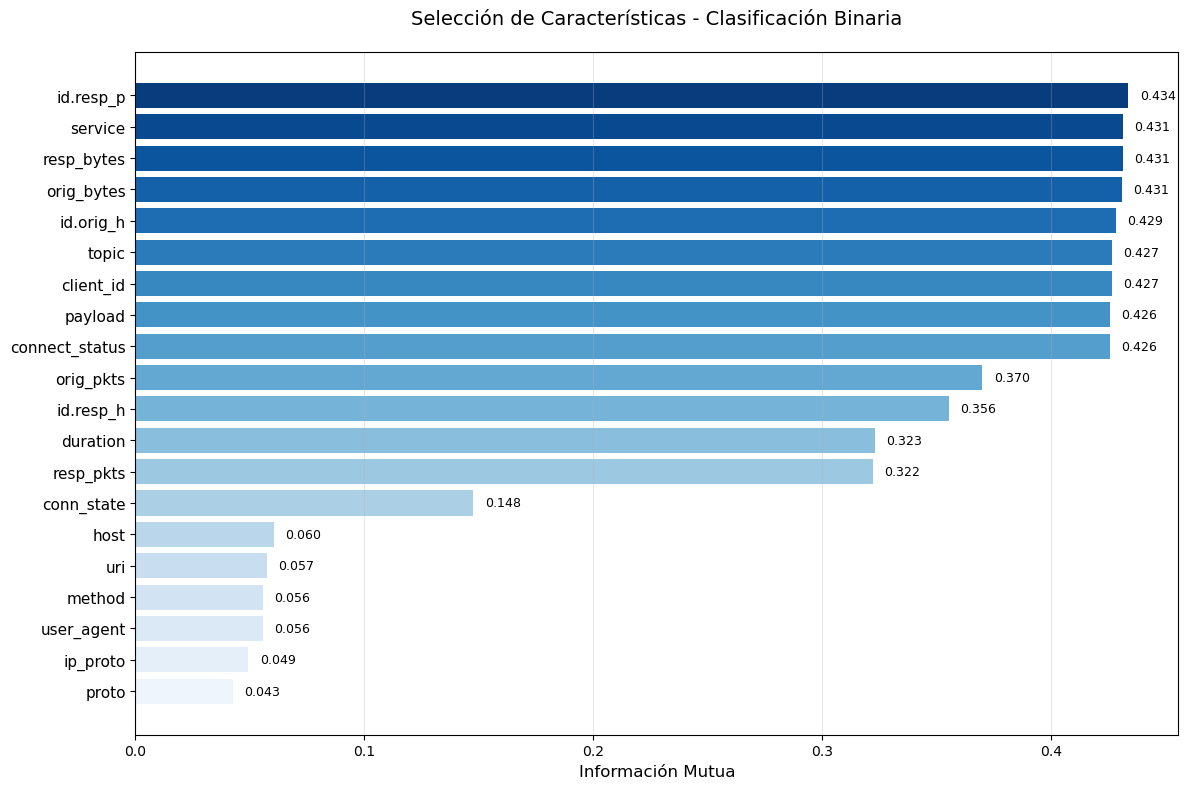

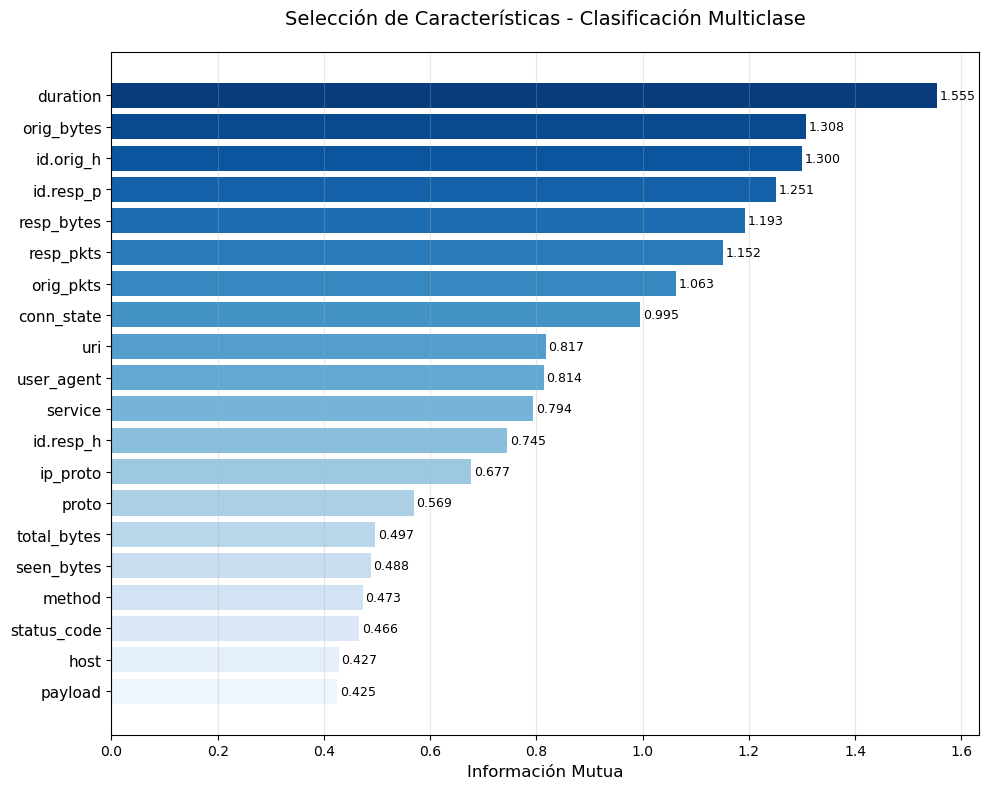

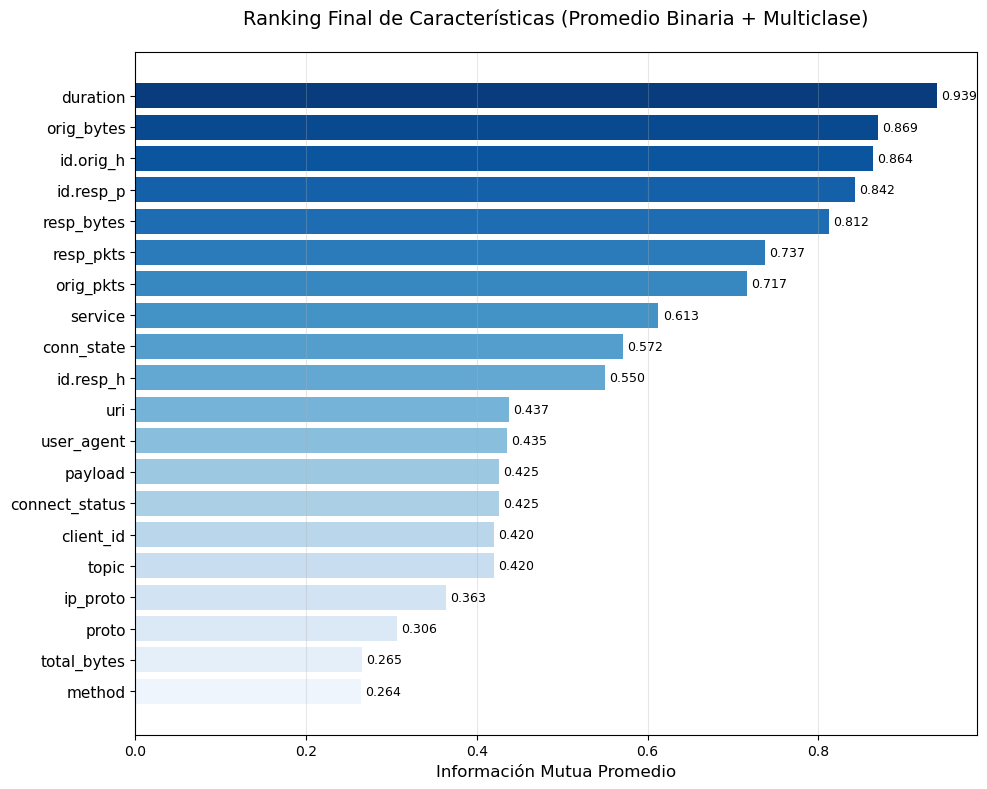

In [9]:
# 7.1 Análisis de Selección de Características basado en Información Mutua
print("\n=== ANÁLISIS DE SELECCIÓN DE CARACTERÍSTICAS ===")
print("Método: Información Mutua (Mutual Information)")
print("Justificación: Detecta relaciones lineales y no lineales entre variables y objetivos")

# Preparar datos para análisis (solo variables numéricas)
X = df_balanced.select_dtypes(include=[np.number]).copy()
y_multiclass = df_balanced['typeAttack'].copy()

# Codificar variable objetivo multiclase para análisis
le_target = LabelEncoder()
y_multiclass_encoded = le_target.fit_transform(y_multiclass)
y_binary = df_balanced['isAttack'].copy()

# Eliminar variables objetivo del conjunto de features
feature_cols = [col for col in X.columns if col not in ['isAttack']]
X_features = X[feature_cols].copy()

print(f"Variables disponibles para análisis: {len(X_features.columns)}")

# 7.1.1 Análisis de Información Mutua para Clasificación Binaria
print("\n  Calculando Información Mutua para clasificación binaria...")
mi_binary = mutual_info_classif(X_features, y_binary, random_state=42)
mi_binary_df = pd.DataFrame({
    'feature': X_features.columns,
    'mi_binary': mi_binary
}).sort_values('mi_binary', ascending=False)

#print("Top 20 características para clasificación binaria (Normal vs Ataque):")
#print(mi_binary_df.head(20))

# 7.1.2 Análisis de Información Mutua para Clasificación Multiclase
print("\n  Calculando Información Mutua para clasificación multiclase...")
mi_multiclass = mutual_info_classif(X_features, y_multiclass_encoded, random_state=42)
mi_multiclass_df = pd.DataFrame({
    'feature': X_features.columns,
    'mi_multiclass': mi_multiclass
}).sort_values('mi_multiclass', ascending=False)

#print("Top 20 características para clasificación multiclase (20 tipos de amenazas):")
#print(mi_multiclass_df.head(20))

# 7.1.3 Combinación de Información Mutua
print("\n  Combinando resultados de ambas clasificaciones...")
mi_analysis = mi_binary_df.merge(mi_multiclass_df, on='feature')
mi_analysis['avg_mi'] = (mi_analysis['mi_binary'] + mi_analysis['mi_multiclass']) / 2
mi_analysis = mi_analysis.sort_values('avg_mi', ascending=False)

#print("Top 20 características (Información Mutua Promedio):")
#print(mi_analysis.head(20)[['feature', 'avg_mi', 'mi_binary', 'mi_multiclass']])

# 7.1.4 Visualización de Información Mutua
print("\n  Generando visualizaciones de Información Mutua...")

top_n = 20
blues = sns.color_palette("Blues", n_colors=top_n)
blues_reversed = list(reversed(blues))

# Gráfico 1: MI Binaria
print("    Creando gráfico de MI para clasificación binaria...")
plt.figure(figsize=(12, 8))
top_mi_binary = mi_binary_df.head(top_n)
bars1 = plt.barh(range(len(top_mi_binary)), top_mi_binary['mi_binary'], color=blues_reversed)
plt.yticks(range(len(top_mi_binary)), top_mi_binary['feature'], fontsize=11)
plt.xlabel('Información Mutua', fontsize=12)
plt.title('Selección de Características - Clasificación Binaria', 
          fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, bar in enumerate(bars1):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('preprocess/mi_binary_classification.png', dpi=300, bbox_inches='tight')
#plt.show()

# Gráfico 2: MI Multiclase
print("    Creando gráfico de MI para clasificación multiclase...")
plt.figure(figsize=(10, 8))
top_mi_multi = mi_multiclass_df.head(top_n)
bars2 = plt.barh(range(len(top_mi_multi)), top_mi_multi['mi_multiclass'], color=blues_reversed)
plt.yticks(range(len(top_mi_multi)), top_mi_multi['feature'], fontsize=11)
plt.xlabel('Información Mutua', fontsize=12)
plt.title('Selección de Características - Clasificación Multiclase', 
          fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, bar in enumerate(bars2):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('preprocess/mi_multiclass_classification.png', dpi=300, bbox_inches='tight')
#plt.show()

# Gráfico 3: MI Promedio (Ranking Final)
print("    Creando gráfico de ranking final...")
plt.figure(figsize=(10, 8))
top_mi_avg = mi_analysis.head(top_n)
bars3 = plt.barh(range(len(top_mi_avg)), top_mi_avg['avg_mi'], color=blues_reversed)
plt.yticks(range(len(top_mi_avg)), top_mi_avg['feature'], fontsize=11)
plt.xlabel('Información Mutua Promedio', fontsize=12)
plt.title('Ranking Final de Características (Promedio Binaria + Multiclase)', 
          fontsize=14, pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Añadir valores en las barras
for i, bar in enumerate(bars3):
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('preprocess/mi_final_ranking.png', dpi=300, bbox_inches='tight')
#plt.show()

print("✓ Gráficos guardados:")

# 7.1.5 Selección final de características
top_features_count = 20
top_features = mi_analysis.head(top_features_count)['feature'].tolist()

print(f"\n=== TOP {top_features_count} CARACTERÍSTICAS SELECCIONADAS ===")
print("Criterio: Mayor Información Mutua promedio (Binaria + Multiclase)")
print()
for i, feat in enumerate(top_features, 1):
    row = mi_analysis[mi_analysis['feature'] == feat].iloc[0]
    print(f"  {i:2d}. {feat}")

# Crear dataset con top características para análisis de correlación
X_top_features = X_features[top_features].copy()
print(f"\n✓ Dataset reducido creado con {len(top_features)} características para análisis de correlación")

### Correlación


=== ANÁLISIS DE CORRELACIÓN ===
Calculando matriz de correlación para top características...


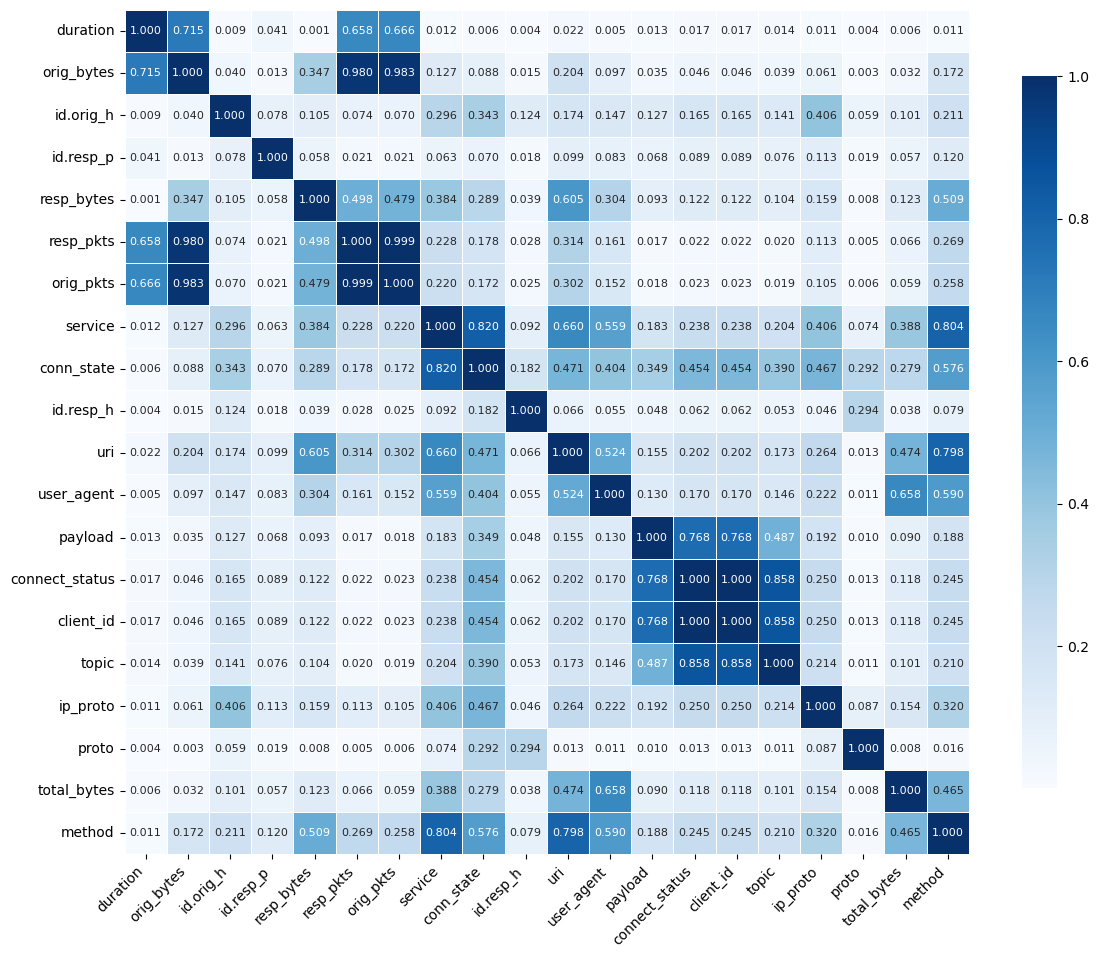


Pares de variables con correlación > 0.9: 4
Pares altamente correlacionados:
  orig_bytes ↔ resp_pkts: 0.980
  orig_bytes ↔ orig_pkts: 0.983
  resp_pkts ↔ orig_pkts: 0.999
  connect_status ↔ client_id: 1.000
  → Eliminar resp_pkts (corr: 0.980, score: 0.737132)
  → Eliminar orig_pkts (corr: 0.983, score: 0.716573)
  → Eliminar client_id (corr: 1.000, score: 0.420440)

Características finales después de eliminar correlaciones:
  Características iniciales: 40
  Top características seleccionadas: 20
  Eliminadas por alta correlación: 3
  Características finales: 17

Lista de características finales:
   1. duration: 0.938926
   2. orig_bytes: 0.869387
   3. id.orig_h: 0.864026
   4. id.resp_p: 0.842462
   5. resp_bytes: 0.812430
   6. service: 0.612694
   7. conn_state: 0.571547
   8. id.resp_h: 0.550136
   9. uri: 0.437269
  10. user_agent: 0.434888
  11. payload: 0.425496
  12. connect_status: 0.425445
  13. topic: 0.420199
  14. ip_proto: 0.363294
  15. proto: 0.305841
  16. total_byte

In [10]:
print("\n=== ANÁLISIS DE CORRELACIÓN ===")
print("Calculando matriz de correlación para top características...")
correlation_matrix = X_top_features.corr().abs()

# Crear visualización de la matriz de correlación (completa)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='Blues', 
            fmt='.3f',
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8},
            annot_kws={'size': 8})

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('preprocess/correlation_matrix_top_features.png', dpi=300, bbox_inches='tight')
plt.show()

# Encontrar pares de variables altamente correlacionadas (> 0.9)
high_correlation_threshold = 0.9
high_corr_pairs = []

# Solo analizar la matriz triangular superior para evitar duplicados
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if corr_value > high_correlation_threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, corr_value))

print(f"\nPares de variables con correlación > {high_correlation_threshold}: {len(high_corr_pairs)}")
if high_corr_pairs:
    print("Pares altamente correlacionados:")
    for col1, col2, corr_val in high_corr_pairs:
        print(f"  {col1} ↔ {col2}: {corr_val:.3f}")
else:
    print("No se encontraron pares altamente correlacionados.")

# Seleccionar variables a eliminar (mantener la que tenga mayor puntuación combinada)
features_to_remove_corr = []
for col1, col2, corr_val in high_corr_pairs:
    score1 = mi_analysis[mi_analysis['feature'] == col1]['avg_mi'].iloc[0]
    score2 = mi_analysis[mi_analysis['feature'] == col2]['avg_mi'].iloc[0]
    
    # Eliminar la que tenga menor puntuación combinada
    feature_to_remove = col1 if score1 < score2 else col2
    if feature_to_remove not in features_to_remove_corr:
        features_to_remove_corr.append(feature_to_remove)
        print(f"  → Eliminar {feature_to_remove} (corr: {corr_val:.3f}, score: {min(score1, score2):.6f})")

# Crear lista final de características
final_features = [feat for feat in top_features if feat not in features_to_remove_corr]
print(f"\nCaracterísticas finales después de eliminar correlaciones:")
print(f"  Características iniciales: {len(X_features.columns)}")
print(f"  Top características seleccionadas: {len(top_features)}")
print(f"  Eliminadas por alta correlación: {len(features_to_remove_corr)}")
print(f"  Características finales: {len(final_features)}")

print(f"\nLista de características finales:")
for i, feat in enumerate(final_features, 1):
    score = mi_analysis[mi_analysis['feature'] == feat]['avg_mi'].iloc[0]
    print(f"  {i:2d}. {feat}: {score:.6f}")

In [11]:
# 7.3 Aplicar reducción de características
print(f"\nResumen de reducción de características:")
print(f"  Variables originales: {len(X_features.columns)}")
print(f"  Variables en top ranking: {len(top_features)}")
print(f"  Variables eliminadas por correlación: {len(features_to_remove_corr)}")
print(f"  Variables finales: {len(final_features)}")

# Aplicar reducción al dataset balanceado usando las características finales
df_reduced = df_balanced.copy()

# Mantener solo las características finales + variables objetivo
columns_to_keep = final_features + ['typeAttack', 'isAttack']
existing_columns_to_keep = [col for col in columns_to_keep if col in df_reduced.columns]

# Crear dataset final con características seleccionadas
df_reduced = df_reduced[existing_columns_to_keep]

print(f"\nDataset final: {df_reduced.shape}")
print(f"Variables predictoras: {len(final_features)}")
print(f"Variables objetivo: 2 (typeAttack, isAttack)")

# Guardar análisis de características
mi_analysis.to_csv('preprocess/feature_importance_analysis.csv', index=False)
print(f"\n✓ Análisis completo de características guardado en 'feature_importance_analysis.csv'")

# Guardar lista de características finales
final_features_df = pd.DataFrame({
    'feature': final_features,
    'combined_score': [mi_analysis[mi_analysis['feature'] == feat]['avg_mi'].iloc[0] 
                      for feat in final_features]
})
final_features_df.to_csv('preprocess/final_selected_features.csv', index=False)
print(f"✓ Lista de características finales guardada en 'final_selected_features.csv'")


Resumen de reducción de características:
  Variables originales: 40
  Variables en top ranking: 20
  Variables eliminadas por correlación: 3
  Variables finales: 17

Dataset final: (34285, 19)
Variables predictoras: 17
Variables objetivo: 2 (typeAttack, isAttack)

✓ Análisis completo de características guardado en 'feature_importance_analysis.csv'
✓ Lista de características finales guardada en 'final_selected_features.csv'


In [12]:
# 7.3 Aplicar reducción de características
print(f"\nResumen de reducción de características:")
print(f"  Variables originales: {len(X_features.columns)}")
print(f"  Variables en top ranking (MI): {len(top_features)}")
print(f"  Variables eliminadas por correlación: {len(features_to_remove_corr)}")
print(f"  Variables finales: {len(final_features)}")

# Aplicar reducción al dataset balanceado usando las características finales
df_reduced = df_balanced.copy()

# Mantener solo las características finales + variables objetivo
columns_to_keep = final_features + ['typeAttack', 'isAttack']
existing_columns_to_keep = [col for col in columns_to_keep if col in df_reduced.columns]

# Crear dataset final con características seleccionadas
df_reduced = df_reduced[existing_columns_to_keep]

print(f"\nDataset final: {df_reduced.shape}")
print(f"Variables predictoras: {len(final_features)}")
print(f"Variables objetivo: 2 (typeAttack, isAttack)")

# Guardar análisis de Información Mutua
mi_analysis.to_csv('mutual_information_analysis.csv', index=False)
print(f"\n✓ Análisis de Información Mutua guardado en 'mutual_information_analysis.csv'")

# Guardar lista de características finales
final_features_df = pd.DataFrame({
    'feature': final_features,
    'mutual_information': [mi_analysis[mi_analysis['feature'] == feat]['avg_mi'].iloc[0] 
                          for feat in final_features]
})
final_features_df.to_csv('final_selected_features.csv', index=False)
print(f"✓ Lista de características finales guardada en 'final_selected_features.csv'")



Resumen de reducción de características:
  Variables originales: 40
  Variables en top ranking (MI): 20
  Variables eliminadas por correlación: 3
  Variables finales: 17

Dataset final: (34285, 19)
Variables predictoras: 17
Variables objetivo: 2 (typeAttack, isAttack)

✓ Análisis de Información Mutua guardado en 'mutual_information_analysis.csv'
✓ Lista de características finales guardada en 'final_selected_features.csv'


## Normalizacion
No la hago aqui, si no después de la particion train-test para evitar data leakage

## Verificaciones finales y guardado

In [14]:
print("\n=== VERIFICACIONES FINALES ===")

# Verificar que no hay valores nulos en variables predictoras
predictor_cols = [col for col in df_reduced.columns if col not in ['typeAttack', 'isAttack']]
null_check = df_reduced[predictor_cols].isnull().sum().sum()
print(f"Valores nulos en variables predictoras: {null_check}")

# Verificar distribución binaria
binary_dist = df_reduced['isAttack'].value_counts()
print(f"Distribución binaria - Normal: {binary_dist.get(0, 0):,}, Ataques: {binary_dist.get(1, 0):,}")

# Verificar distribución de clases
final_class_dist = df_reduced['typeAttack'].value_counts()
print(f"Distribución final de clases: {len(final_class_dist)} clases")

print("\n=== GUARDADO ===")

# Guardar dataset procesado
df_reduced.to_csv('preprocess/ML_NG-IIoTset.csv', index=False)
print("✓ CSV guardado: ML_NG-IIoTset.csv")

# Guardar en formato pickle
with open('preprocess/ML_NG-IIoTset.pkl', 'wb') as f:
    pickle.dump(df_reduced, f)
print("✓ PKL guardado: ML_NG-IIoTset.pkl")

# Guardar  encoders
joblib.dump(label_encoders, 'preprocess/label_encoders.pkl')
joblib.dump(le_target, 'preprocess/target_encoder.pkl')
print("✓ encoders guardados")


=== VERIFICACIONES FINALES ===
Valores nulos en variables predictoras: 0
Distribución binaria - Normal: 5,656, Ataques: 28,629
Distribución final de clases: 15 clases

=== GUARDADO ===
✓ CSV guardado: ML_NG-IIoTset.csv
✓ PKL guardado: ML_NG-IIoTset.pkl
✓ encoders guardados


## Resumen final

In [16]:
print("\n" + "="*60)
print("RESUMEN DEL PREPROCESAMIENTO")
print("="*60)
print(f"Dataset original: {df_original.shape[0]:,} × {df_original.shape[1]}")
print(f"Duplicados eliminados: {duplicate_count:,}")
print(f"Dataset balanceado: {len(df_balanced):,} × {len(df_balanced.columns)}")
print(f"Top características seleccionadas: {len(top_features)}")  
print(f"Variables eliminadas por correlación: {len(features_to_remove_corr)}")   
print(f"Dataset final: {df_reduced.shape[0]:,} × {df_reduced.shape[1]}")
print(f"Variables predictoras finales: {len(predictor_cols)}")
print(f"Reducción de registros: {(1 - len(df_reduced)/len(df_original))*100:.2f}%")
print(f"Reducción de memoria: {memory_reduction:.2f}%")

print("\nTransformaciones aplicadas:")
print("  ✓ Timestamp transformado con datetime")
print("  ✓ IPs transformadas con ipaddress")
print("  ✓ Tipos de datos optimizados")
print("  ✓ Duplicados eliminados")
print("  ✓ Clases balanceadas proporcionalmente")
print("  ✓ Variables categóricas codificadas")
print("  ✓ Análisis de importancia realizado")
print("  ✓ Variables correlacionadas eliminadas")


print("\n✅ Dataset listo para entrenamiento de modelos ML")
print("="*60)


RESUMEN DEL PREPROCESAMIENTO
Dataset original: 18,982,712 × 45
Duplicados eliminados: 11,294,503
Dataset balanceado: 34,285 × 42
Top características seleccionadas: 20
Variables eliminadas por correlación: 3
Dataset final: 34,285 × 19
Variables predictoras finales: 17
Reducción de registros: 99.82%
Reducción de memoria: 76.50%

Transformaciones aplicadas:
  ✓ Timestamp transformado con datetime
  ✓ IPs transformadas con ipaddress
  ✓ Tipos de datos optimizados
  ✓ Duplicados eliminados
  ✓ Clases balanceadas proporcionalmente
  ✓ Variables categóricas codificadas
  ✓ Análisis de importancia realizado
  ✓ Variables correlacionadas eliminadas

✅ Dataset listo para entrenamiento de modelos ML
